In [1]:
import os
from pathlib import Path
from dotenv import load_dotenv
import pandas as pd

from main import main

from query import DataLoader

load_dotenv()

groq_key = os.environ['groqkey']

data_path = Path(os.environ['data_path'])


/Users/reedevans/Documents/mids/deprescribe_main/DataSci210_MedicationDeprescriber/src/extraction.py:15: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="NeuML/pubmedbert-base-embeddings")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [16]:
dl = DataLoader(data_path)

labeled_df = dl.get_label_df()
#labeled_df = labeled_df.sample(10)
labeled_df.head()

,review_by,validated_by,key,reason,recommendation,diagnosis,GS_response,Note
0,Ben,NaN,D6253A5CE371EA,example with gastrointestinal bleed should con...,continue,3-Upper GI Bleed,This patient has a history of a gastrointestin...,NaN
1,Ben,NaN,DFAFED1811B871,example with a documented history of a GI blee...,continue,3-Upper GI Bleed,This patient has a history of a gastrointestin...,NaN
2,Ben,NaN,D4865B8BBB294E,example with GI bleeding that occurred during ...,continue,3-Upper GI Bleed,GI bleeding developed during hospital stay and...,NaN
3,Ben,NaN,D00F3A8D5F43B2,example with symptoms of heartburn (upper GI s...,deprescribe,9-Treated GERD,09/20/2023 inpatient nursing note mentions use...,NaN
4,Ben,NaN,DA15CCF42ACF8B,"Barrett's esophagus, continue PPI",continue,0-Barrett's Esophagus,Patient should continue lansoprazole 30mg ever...,NaN


In [18]:
notes = pd.read_csv(dl.data_path / "labled_notes_w_summary.csv")

In [24]:
unmatched_df = labeled_df.merge(notes, left_on='key', right_on='EncounterKey', how='left', indicator=True)
unmatched_rows = unmatched_df[unmatched_df['_merge'] == 'left_only']

# Display the unmatched rows
unmatched_rows

,review_by,validated_by,key_x,reason,recommendation,diagnosis,GS_response,Note,deid_note_key,EncounterKey,...,DepartmentSpecialty,ProviderSpecialty,ProviderType,NoteText,is_on_last_note_date,key_y,PtDischargeDate,discharge_text,llm_summary,_merge
1513,Ben,NaN,SyntheticPt6,no notes about esomeprazole 40mg,deprescribe,10-No Diagnosis,No indication why patient is taking,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [3]:
for index, row in labeled_df.iterrows():
    encounter_key = row["key"]
    ret_recommendation, ret_reasoning, token_usage, search_history_so_far, token_count_history = main(
        groq_key=groq_key, data_path=data_path, encounter_key=encounter_key
    )
    print(ret_recommendation)
    labeled_df.at[index, 'ret_recommendation'] = ret_recommendation
    labeled_df.at[index, 'ret_reasoning'] = ret_reasoning
    labeled_df.at[index, 'token_usage'] = token_usage
    labeled_df.at[index, 'search_history_so_far'] = str(search_history_so_far)
    labeled_df.at[index, 'token_count_history'] = str(token_count_history)



deprescribe
stop
deprescribe
continue
deprescribe


IndexError: list index out of range

In [6]:
labeled_df = labeled_df[labeled_df.token_usage > 0]

Accuracy: 1.0000
Precision (Macro Avg): 1.0000
Recall (Macro Avg): 1.0000
F1 Score (Macro Avg): 1.0000

Classification Report:
               precision    recall  f1-score   support

    continue       1.00      1.00      1.00         1
 deprescribe       1.00      1.00      1.00         3
        stop       1.00      1.00      1.00         1

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



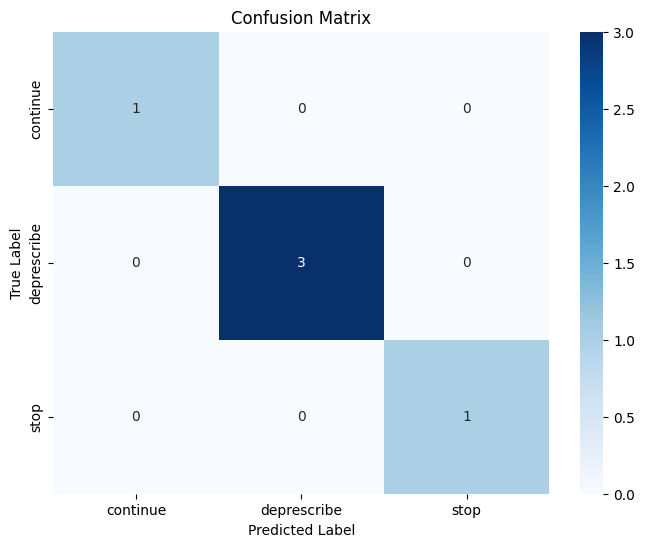

In [7]:
from eval import evaluate_multiclass_classification, get_best_diagnosis_match

y_true = labeled_df['recommendation']
y_pred = labeled_df['ret_recommendation']
class_labels = ['continue', 'deprescribe', 'stop']

# Evaluate the model
metrics = evaluate_multiclass_classification(y_true, y_pred, class_labels)

In [11]:
labeled_df['diagnosis_key'] = labeled_df['diagnosis'].str.split('-').str[0]

/var/folders/8w/6bqg5xh14393yv1z0lhtm2z40000gn/T/ipykernel_57421/3775046982.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_df['diagnosis_key'] = labeled_df['diagnosis'].str.split('-').str[0]


In [12]:
for index, row in labeled_df.iterrows():
    matched_diagnosis_key, matched_diagnosis_label = get_best_diagnosis_match(row.ret_reasoning)
    labeled_df.at[index, 'matched_diagnosis_key'] = matched_diagnosis_key
    labeled_df.at[index, 'matched_diagnosis_label'] = matched_diagnosis_label
    

In [15]:
labeled_df.to_csv('sample_results.csv', index=False)